### Conditional Variational Autoencoder Implementation
##### as of 4/14/2022 

In [11]:
import torch
import torchvision
import sklearn.metrics # r2_score(y_true, y_predicted)
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utilities
#import plotting

import emulator_cvae

In [2]:
def save_model_to_file(model_name,model):
    PATH = f'{model_name}.pt'
    torch.save(model.state_dict(),PATH)
    
# model=emulator_vae_0.VariationalAutoencoderOG
# model_params=(latent_dim, N, N, hidden_dims)
def load_model(model_name,model, model_params):
    model_load = model(model_params)
    PATH = f'{model_name}.pt'
    model_load.load_state_dict(torch.load(PATH))
    return model_load

In [3]:
"""
Plots observed velocity, produced velocity for model 1 and produced velocity for model 2
:x = observed velocity fields
:xp = produced velocity fields for model 1
:xp2 = produced velocity fields for model 2
:u_obs = coordinates for velocity fields
:m_name = model 1 label
:m_name2 = model 2 label
:n_rows = number of fields to sample --> will randomly sample from all observed fields and display produced fields alongside
"""
def plot_reconstructed_compare_multi(x, xp, xp2, u_obs, m_name="", m_name2="", n_rows=5):

    fig, axs = plt.subplots(nrows=n_rows,ncols=3,figsize=(18,4*n_rows))
    set_title = True
    indices = np.arange(x.shape[0])
    f_vals = x
    
    for ax in axs:
        sample_index = np.random.choice(indices)
        c_vals = f_vals[sample_index]
        
        im = ax[0].scatter(u_obs.x[:,0],u_obs.x[:,1],c=x[sample_index],vmin=min(c_vals),vmax=max(c_vals))
        im2 = ax[1].scatter(u_obs.x[:,0],u_obs.x[:,1],c=xp[sample_index],vmin=min(c_vals),vmax=max(c_vals))
        im3 = ax[2].scatter(u_obs.x[:,0],u_obs.x[:,1],c=xp2[sample_index],vmin=min(c_vals),vmax=max(c_vals))

        ax[1].set_xticks([])
        ax[0].set_xticks([])
        ax[1].set_yticks([])
        ax[0].set_yticks([])
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        
        ax[0].set_xlabel(f"Data Index: {sample_index}")
        
        if set_title:
            ax[0].set_title("Observed")
            ax[1].set_title(f"Reconstructed with {m_name} \n MSE: " 
                            + f"{sklearn.metrics.mean_squared_error(x[sample_index],xp[sample_index]):0.6f}"
                            + f" R2: {sklearn.metrics.r2_score(x[sample_index],xp[sample_index]):0.6f}")
            
            ax[2].set_title(f"Reconstructed with {m_name2} \n MSE: " 
                            + f"{sklearn.metrics.mean_squared_error(x[sample_index],xp2[sample_index]):0.6f}"
                            + f" R2: {sklearn.metrics.r2_score(x[sample_index],xp2[sample_index]):0.6f}")
            set_title = False
        else:
            ax[1].set_title(f"MSE: {sklearn.metrics.mean_squared_error(x[sample_index],xp[sample_index]):0.6f}"
                        + f" R2: {sklearn.metrics.r2_score(x[sample_index],xp[sample_index]):0.6f}")

            ax[2].set_title(f"MSE: {sklearn.metrics.mean_squared_error(x[sample_index],xp2[sample_index]):0.6f}"
                        + f" R2: {sklearn.metrics.r2_score(x[sample_index],xp2[sample_index]):0.6f}")

        plt.colorbar(im,ax=ax[2])

"""
see plot_reconstructed_compare_multi() method description
same, but for comparing 1 model results to observed values
:rand = randomly sample, otherwise produce plots for first N datapoints
"""       
def plot_reconstructed_compare(x, xp, u_obs,n_rows=5,rand=False):

    fig, axs = plt.subplots(nrows=n_rows,ncols=2,figsize=(14,5*n_rows))
    set_title = True
    indices = np.arange(x.shape[0])
    i = 0
    for ax in axs:
        if rand:
            sample_index = np.random.choice(indices)
        else:
            sample_index = i
        i+=1

        c_vals = np.array([x[sample_index].cpu().detach().numpy()]).flatten()
        #,xp[sample_index].detach().numpy()]).flatten()
        
        im = ax[0].scatter(u_obs.x[:,0],u_obs.x[:,1],c=x[sample_index].cpu().detach().numpy(),vmin=min(c_vals),vmax=max(c_vals))
        im2 = ax[1].scatter(u_obs.x[:,0],u_obs.x[:,1],c=xp[sample_index].cpu().detach().numpy(),vmin=min(c_vals),vmax=max(c_vals))
        ax[1].set_xticks([])
        ax[0].set_xticks([])
        ax[1].set_yticks([])
        ax[0].set_yticks([])
        ax[0].set_xlabel(f"Index: {sample_index}")

        ax[1].set_title("R2 = %0.6f" % sklearn.metrics.r2_score(x[sample_index].detach().numpy(),xp[sample_index].detach().numpy()))
        if set_title:
            ax[0].set_title("Observed")
            ax[1].set_title("Reconstructed\n R2 = %0.6f" % sklearn.metrics.r2_score(x.detach().numpy(),xp.detach().numpy()))
            set_title = False

        plt.colorbar(im2,ax=ax[1])
        
"""
plots comparison of observed vs predicted for one index
:f = unpacked array of velocity field values: array shape = (747)
:fp = unpacked array of predicted velocity field values = (747)
:u_obs = coordinates for velocity fields
"""
def plot_two(f,fp,u_obs):
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(18,4))
    
    im0 = axs[0].scatter(u_obs.x[:,0],u_obs.x[:,1],c=f)
    im1 = axs[1].scatter(u_obs.x[:,0],u_obs.x[:,1],c=fp)
    
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])

    axs[0].set_title("Observed")
    axs[1].set_title(f"Reconstructed \n " 
                    + f"MSE: {sklearn.metrics.mean_squared_error(f,fp):0.6f}"
                    + f" R2: {sklearn.metrics.r2_score(f,fp):0.6f}")
    
    plt.colorbar(im0,ax=axs[0])
    plt.colorbar(im1,ax=axs[1])
    plt.show()
    
"""
plots latent space for first 2 latent dimensions for conditional autoencoder
:cvae = trained conditional autoencoder
:data = torch DataLoader with x=X_hat, y=F
:num_batches = number of points to plot
"""
def plot_latent(cvae, data,num_batches=256):
    for i, (x,y) in enumerate(data):
        encoder_input = torch.cat((y,x),1)
        z,mu,sigma = cvae.encoder(encoder_input)

        z = z.cpu().detach().numpy()
        plt.scatter(z[:,0],z[:,1])
        if i > num_batches:
            plt.colorbar()
            fig = plt.gcf()
            fig.set_size_inches(12,12)
            plt.xlabel("z_0")
            plt.ylabel("z_1")
            plt.show()
            break

"""
generates 100 velocity field results from trained cvae
:cvae = trained conditional autoencoder
:F = velocity field data (Nx747)
:X_hat = parameters (Nx8)
:num_samples = number of generated field sets to produce
:sample_index = index of parameter data to input into cvae --> parameters to use
:latent_dim = latent dimension used to train autoencoder
:log_var = take the log of the variance when plotting
"""
def generate_data_display_mean_std(cvae,F,X_hat,num_samples, sample_index,latent_dim,log_var=False):
    generated_vals = []
    cvae.eval()
    
    for i in range(num_samples):
        z_rand = torch.normal(0,1,size=(1,latent_dim))

        decoder_input = torch.cat((z_rand.to(device),X_hat[sample_index].reshape((1,8))),1)
        F_prime = cvae.decoder(decoder_input)
        generated_vals.append(F_prime.cpu().detach().numpy().squeeze())

    generated_vals = np.array(generated_vals)
    
    plot_mean_std(F.cpu().detach().numpy().squeeze(),sample_index,generated_vals,log_var)
         
"""
plots mean and standard deviation of the results of generate_data_display_mean_std method
:F = velocity field data (Nx747)
:sample_index = index of parameter data to input into cvae --> parameters used to create generated fields
:generated_vals = generated velocity fields (num_samples x 747)
:log_var = take the log of the variance when plotting
"""
def plot_mean_std(F,sample_index,generated_vals,log_var):
    
    m = np.mean(generated_vals,axis=0) # find mean of all produced velocity values for each point
    sigma = np.std(generated_vals,axis=0) # find standard deviation between results
    
    if log_var:
        sigma_plot = np.log(sigma)
    else:
        sigma_plot = sigma    
    
    
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(20,4))
    
    im0 = axs[0].scatter(u_obs.x[:,0],u_obs.x[:,1],c=F[sample_index],vmin=min(F[sample_index]),vmax=max(F[sample_index]))
    im1 = axs[1].scatter(u_obs.x[:,0],u_obs.x[:,1],c=m,vmin=min(F[sample_index]),vmax=max(F[sample_index]))
    im2 = axs[2].scatter(u_obs.x[:,0],u_obs.x[:,1],c=sigma_plot)
    
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[2].set_xticks([])

    axs[0].set_title("Observed")
    axs[1].set_title("Mean of Generated Samples")
    axs[2].set_title("Variance of Generated Samples")
    
    fig.suptitle(f"R2 Observed vs Mean Generated: {sklearn.metrics.r2_score(F[sample_index],m):0.6f} " +\
                 f"Variance max: {max(sigma):0.6f} Variance min: {min(sigma):0.6f}",fontsize=14
                )
    
    plt.colorbar(im1,ax=axs[1])
    plt.colorbar(im2,ax=axs[2])
    plt.show()
    
"""
randomly samples from latent space and plots results --> generates new data
:sample_index = index of parameter data to input into cvae --> parameters used to create generated fields
:num_samples = number of generated field sets to produce
:X_hat = parameters (Nx8)
:F = velocity field data (Nx747)
:cvae = trained conditional autoencoder
:mean & std = mean and standard deviation to sample normally from
"""                     
def randomly_sample_index(sample_index,num_samples,X_hat,F,cvae,mean,std):
    for i in range(num_samples):
        z_rand = torch.normal(mean,std,size=(1,latent_dim_c))
        decoder_input = torch.cat((z_rand.to(device),X_hat[sample_index].reshape((1,X_hat.shape[1]))),1)
        F_prime = cvae.decoder(decoder_input)


        plot_two(F[param_index].cpu().detach().numpy().squeeze(), F_prime.cpu().detach().numpy().squeeze(),u_obs)

In [4]:
def train_model_cvae(latent_dim,N,n_params,hidden_dims,epochs,model,lr,data_loader,F,save_model=False, model_name=""):
    
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

    l_vals = []
    test_vals = []
    kl_vals = []
    dl_vals = []
    

    for epoch in range(epochs):
        dl = 0
        kl = 0
        total_loss = 0
        for params,u in data_loader:
            model.train()

            optimizer.zero_grad()

            u_prime, mu, sigma = model(u,params)

            kl = -0.5 * torch.sum(1 + sigma - mu**2 - torch.exp(sigma),axis=1)
            dl = torch.sum((u-u_prime)**2,axis=-1) # L2 loss
            #dl = (1/(u.shape[0]))*torch.sum((u-u_prime)**2,axis=-1) # MSE Loss

            #loss = torch.mean(1e-2*dl+kl) #with MSE
            loss = torch.mean(1e-4*dl+kl) #with L2

            kl_vals.append(torch.mean(kl).item())
            dl_vals.append(torch.mean(kl).item())

            loss.backward()

            optimizer.step()

            total_loss += loss.item()      

        model.eval()

        F_prime = model(F,X_hat,train=False)

        l_vals.append(total_loss/len(data_loader))
        test_vals.append(sklearn.metrics.mean_squared_error(F.cpu().detach().numpy(),F_prime.cpu().detach().numpy()))
        
        if epoch % 10 == 0:
            print(f"{epoch}/{epochs} :".ljust(10) + \
                  f"train {l_vals[-1]:0.4f}".ljust(20) + \
                  f"test {test_vals[-1]:0.4f}".ljust(20) + \
                  f"test R2 {sklearn.metrics.r2_score(F.cpu().detach().numpy(),F_prime.cpu().detach().numpy()):0.4f}"
                 )    

    if save_model:
        save_model_to_file(model_name,model)
        
    # plots loss over time at end of training
    
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
    axs[0].plot(np.array(l_vals))
    axs[0].set_title("Total Loss over Time")

    axs[1].plot(kl_vals,label="kl")
    axs[1].plot(dl_vals,label="mse")
    axs[1].legend()
    axs[1].set_title("KL and MSE Loss over Time")
        
    axs[2].plot(np.array(test_vals))
    axs[2].set_title("Test MSE over Time")
    
    fig.suptitle(f'Final Test MSE = {test_vals[-1]}',fontsize=16)
    plt.show()
    print("Final R2: %.6f"%sklearn.metrics.r2_score(F.cpu().detach().numpy(),F_prime.cpu().detach().numpy()))
    

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device =", device)

Device = cuda


In [6]:
# velocity fields
F_lin = pickle.load(open('data/F_prior.p','rb'))
# load parameters
X = pickle.load(open('data/X_prior.p','rb'))
u_obs = utilities.VData('./data/u_observed.vtu')
point_area = torch.tensor(u_obs.get_point_area(),dtype=torch.float,device=device)
normed_area = point_area/point_area.sum()

# filtering out bad simulations
p = (X[:,1]<1e5)*(X[:,3]>=12)
F_lin = F_lin[p]
X = X[p,6:]
F = np.log10(F_lin)

X = torch.from_numpy(X)
F = torch.from_numpy(F)

X = X.to(torch.float32)
F = F.to(torch.float32)

X = X.to(device)
F = F.to(device)

X_hat = torch.log10(X)

In [7]:
from torch.utils.data import TensorDataset
                         
data_train = TensorDataset(X_hat,F)

batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=data_train,
                                          batch_size=batch_size,
                                          shuffle=True)


0/500 :   train 0.2343        test 1.2777         test R2 0.1533
10/500 :  train 0.0378        test 0.4570         test R2 0.6870
20/500 :  train 0.0235        test 0.2787         test R2 0.8057
30/500 :  train 0.0172        test 0.2254         test R2 0.8414
40/500 :  train 0.0141        test 0.1819         test R2 0.8710
50/500 :  train 0.0132        test 0.1574         test R2 0.8887
60/500 :  train 0.0105        test 0.1419         test R2 0.8985
70/500 :  train 0.0093        test 0.1183         test R2 0.9164
80/500 :  train 0.0085        test 0.1181         test R2 0.9163
90/500 :  train 0.0080        test 0.0926         test R2 0.9344
100/500 : train 0.0072        test 0.0875         test R2 0.9380
110/500 : train 0.0069        test 0.0839         test R2 0.9411
120/500 : train 0.0059        test 0.0779         test R2 0.9449
130/500 : train 0.0055        test 0.0725         test R2 0.9489
140/500 : train 0.0048        test 0.0660         test R2 0.9531
150/500 : train 0.0052   

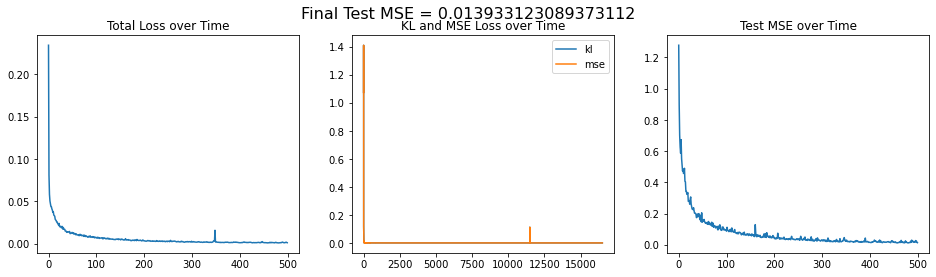

Final R2: 0.990323


In [8]:
latent_dim_c = 40 
N = F.shape[1]
n_params = X_hat.shape[1]
hidden_dims = (512,256)
epochs = 500

cvae = emulator_cvae.ConditionalVariationalAutoencoder(N,n_params,latent_dim_c,hidden_dims)
cvae.to(device)

train_model_cvae(latent_dim_c,N,n_params,hidden_dims,epochs,cvae,1e-3,data_loader,F)


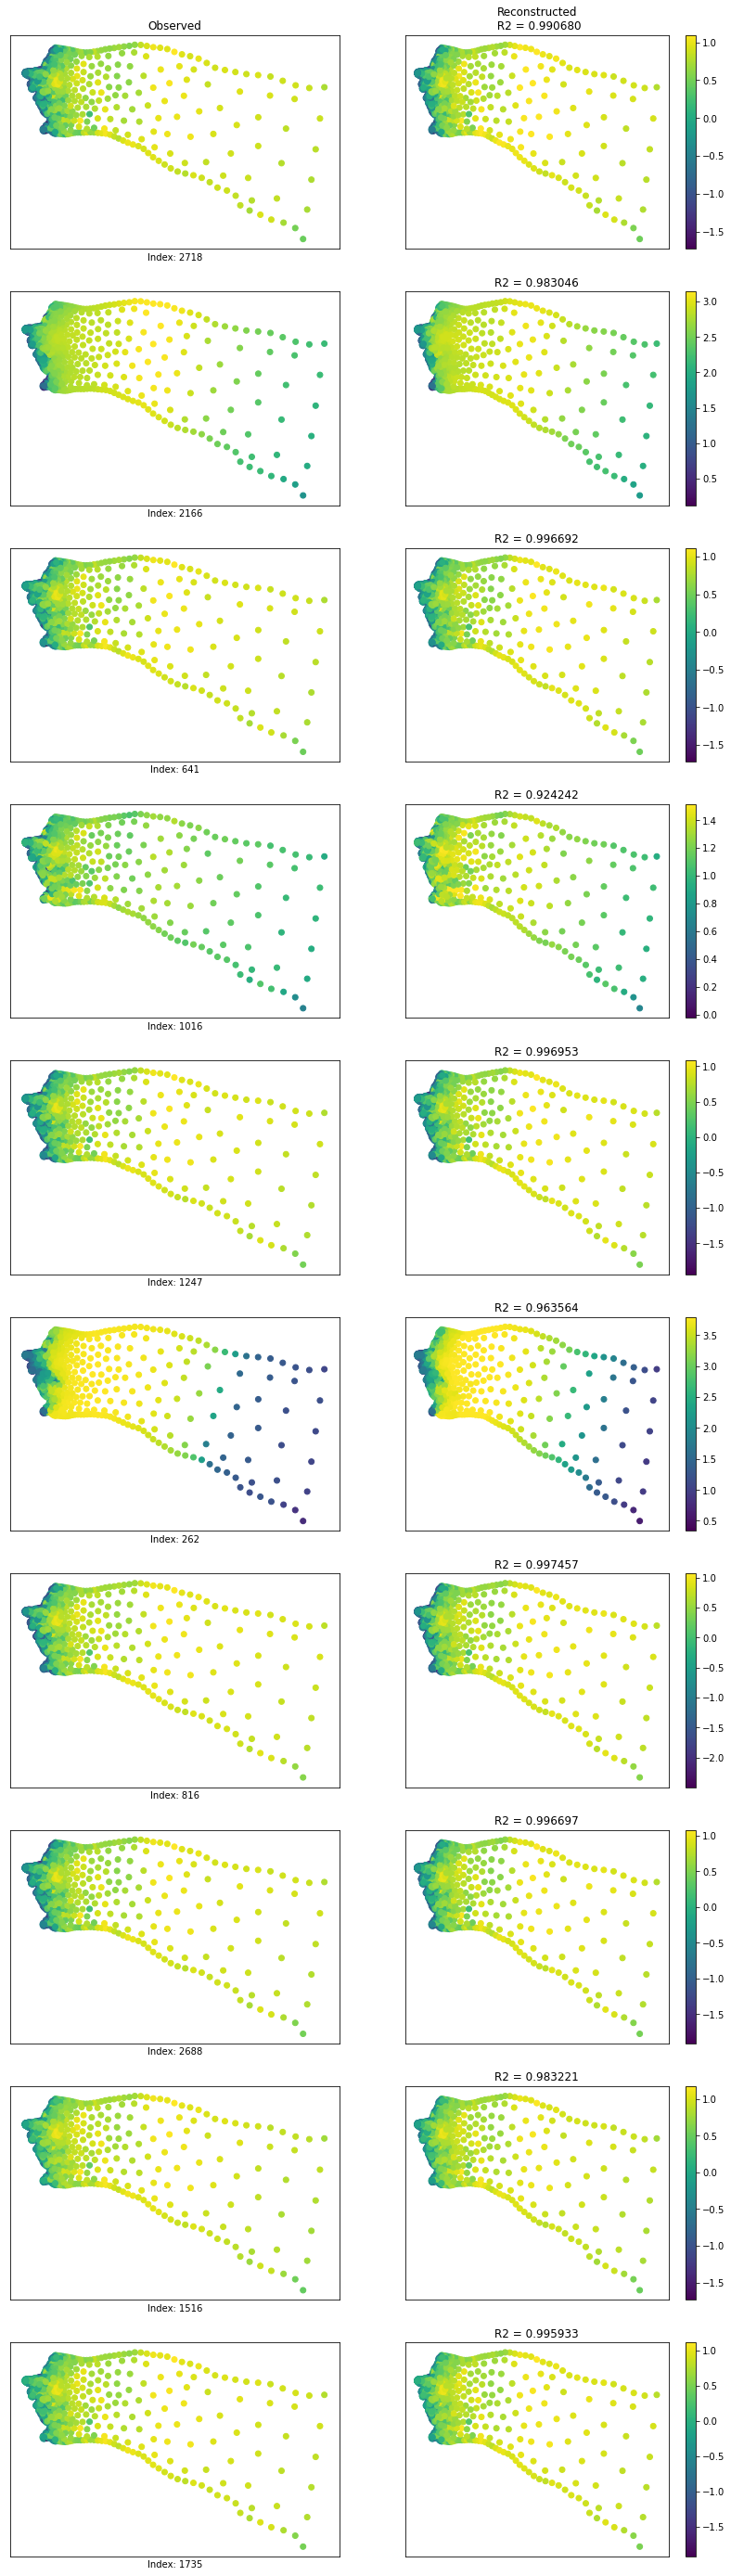

In [9]:
cvae.eval()
Fp40 = cvae(F,X_hat,train=False)

plot_reconstructed_compare(F.cpu(), Fp40.cpu(), u_obs,n_rows=10,rand=True)

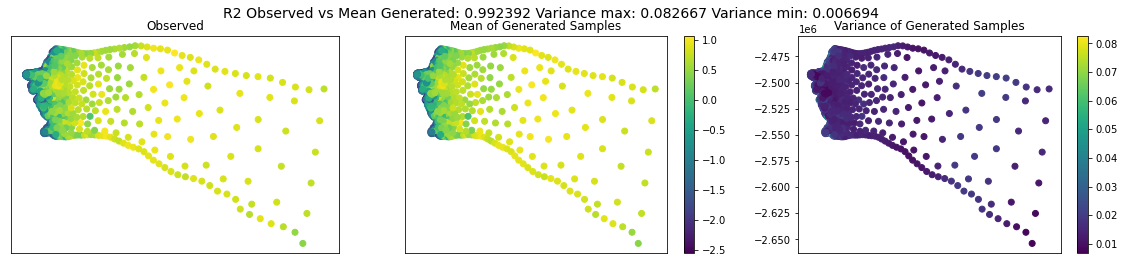

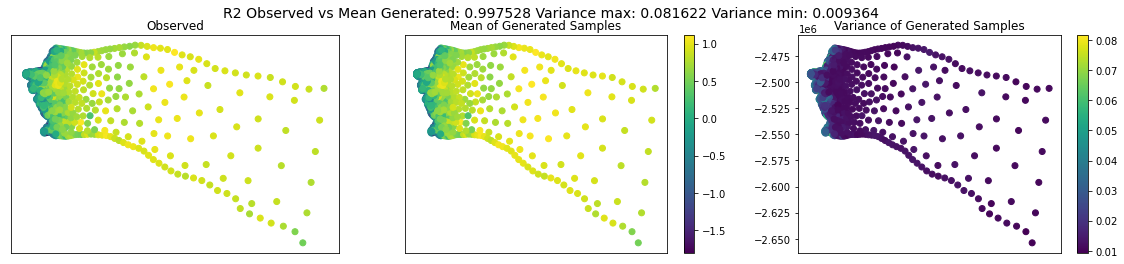

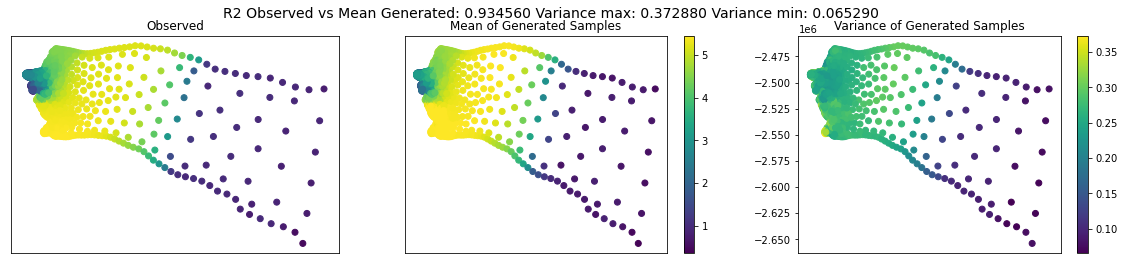

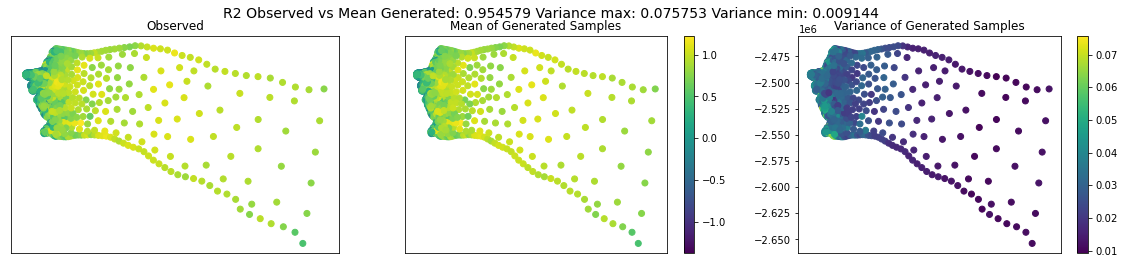

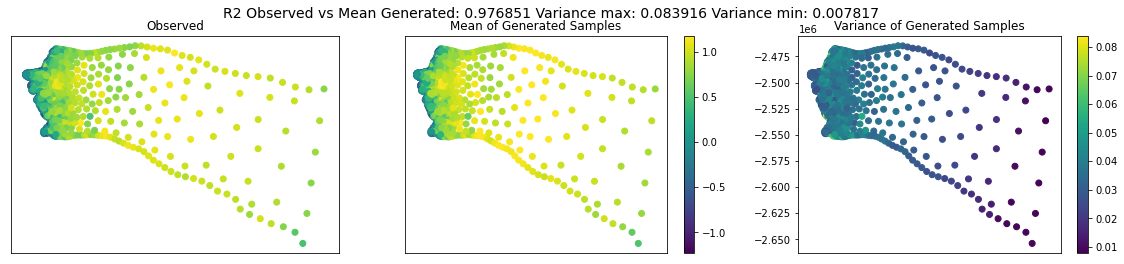

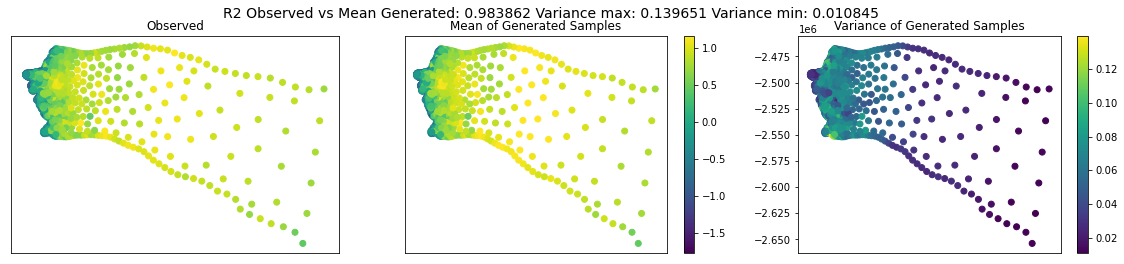

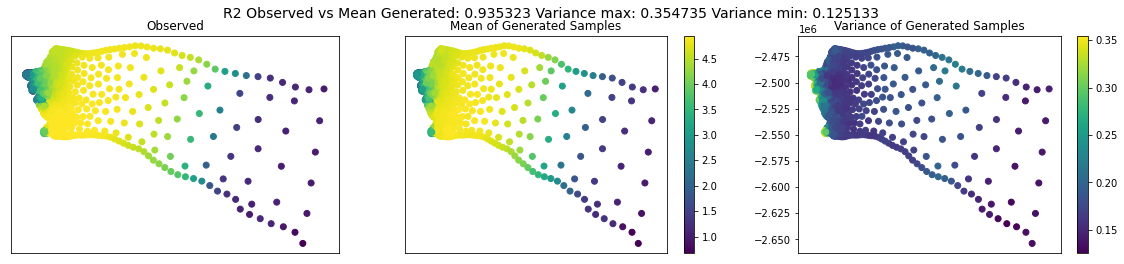

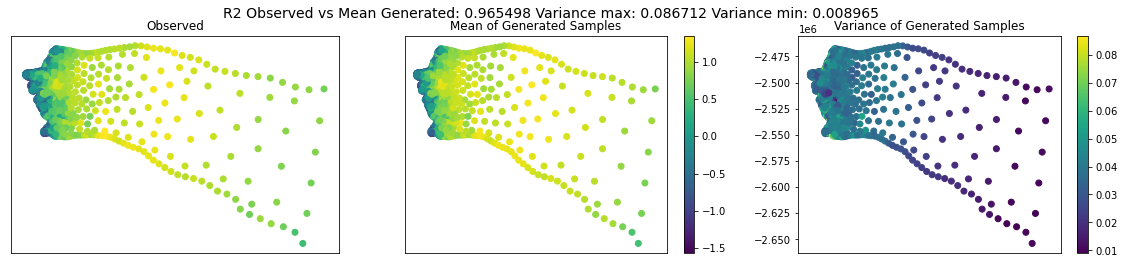

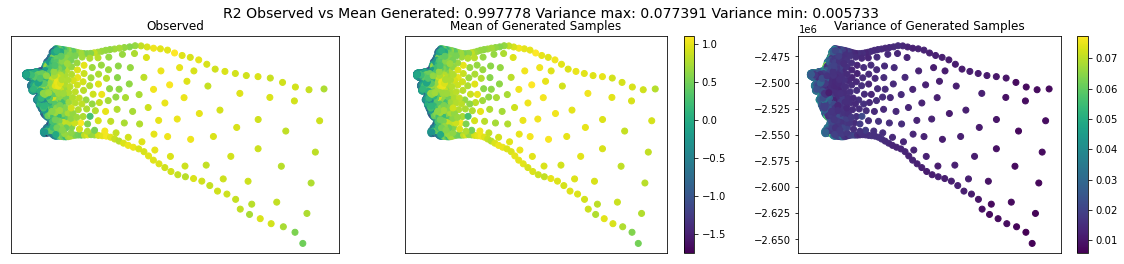

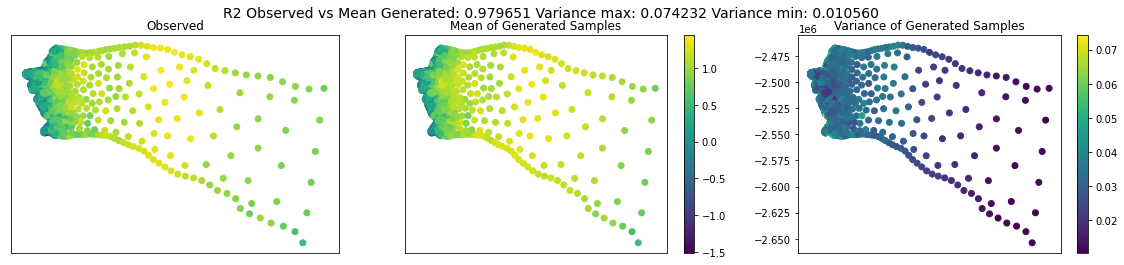

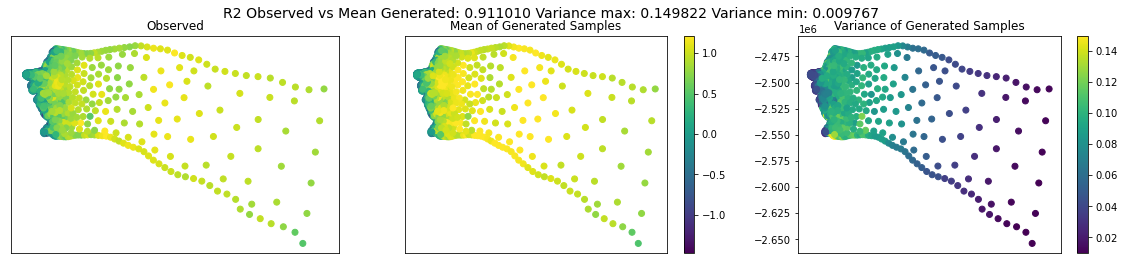

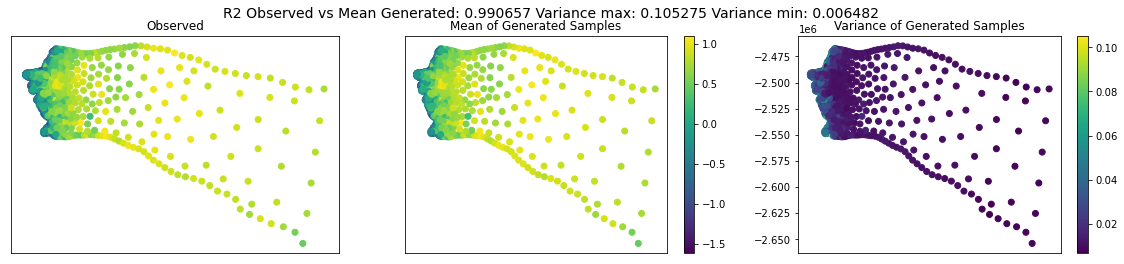

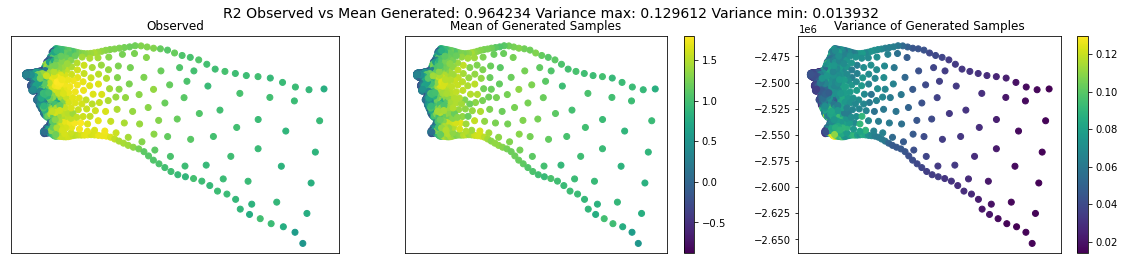

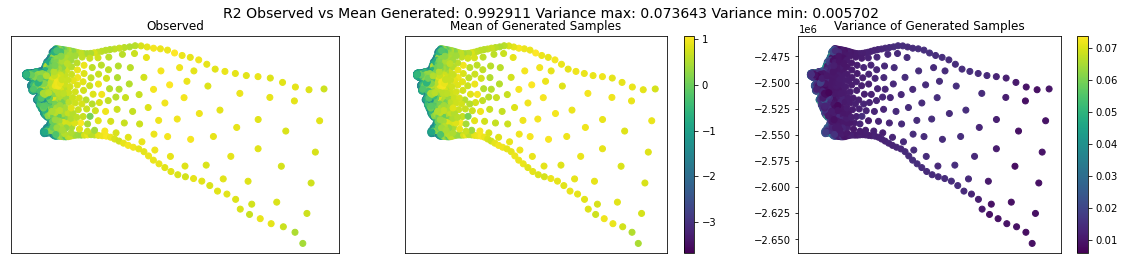

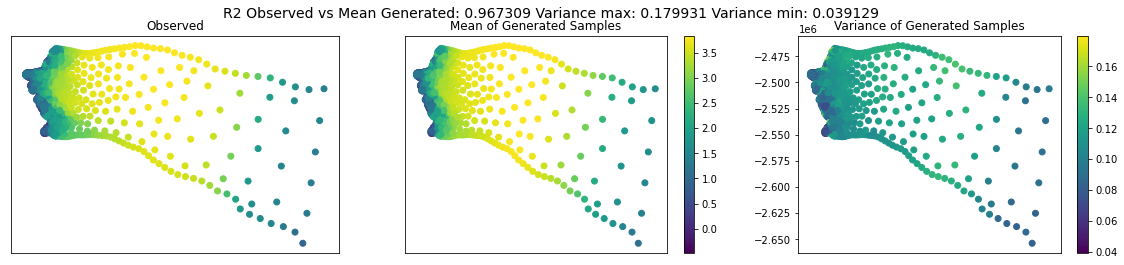

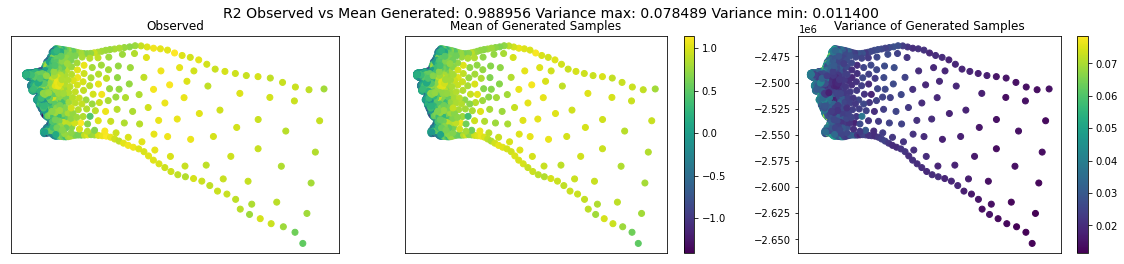

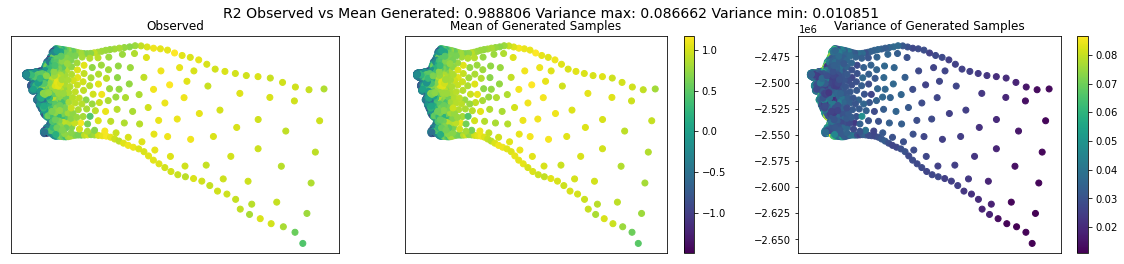

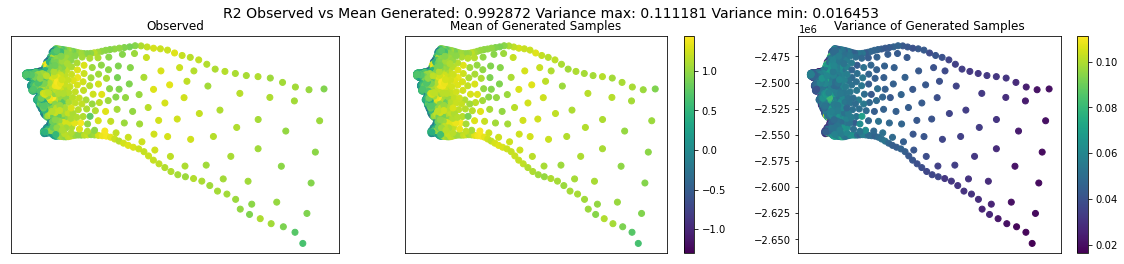

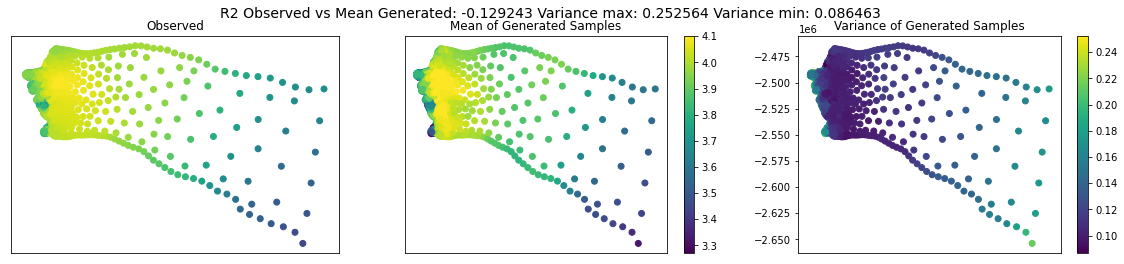

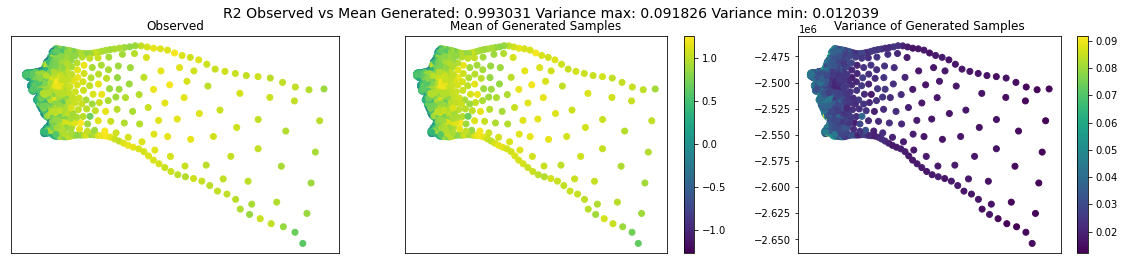

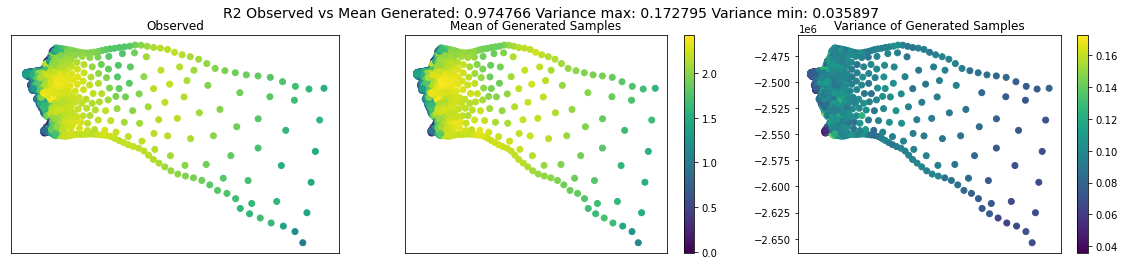

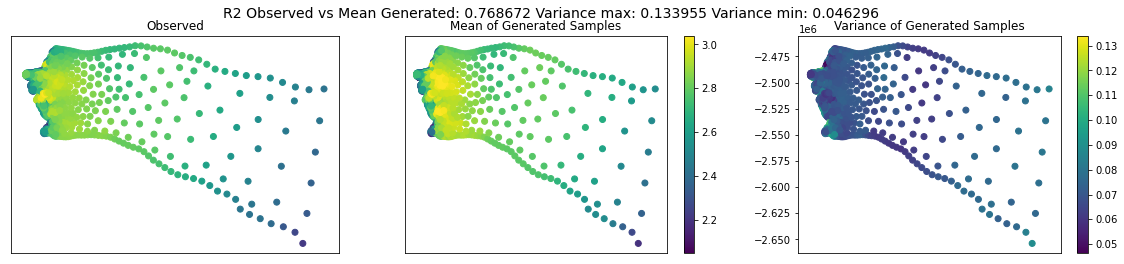

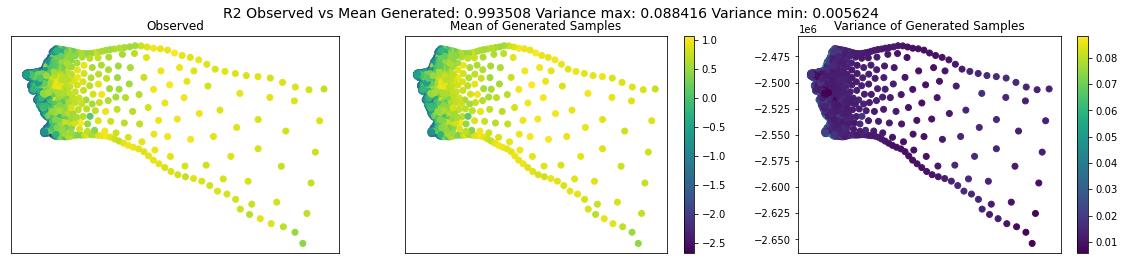

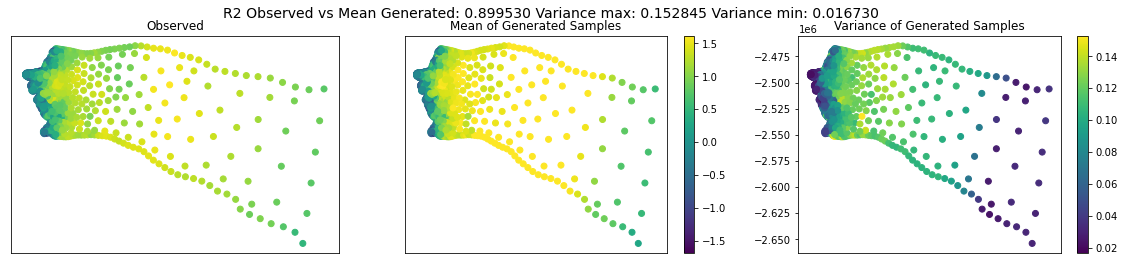

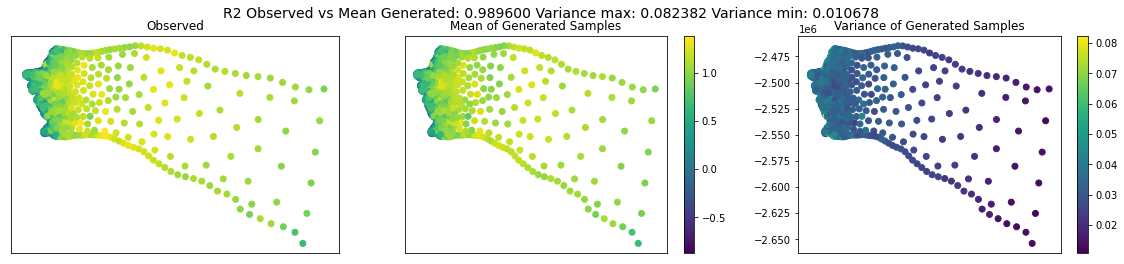

In [10]:
indices = np.arange(F.shape[0])

for i in range(25):
    sample_index = np.random.choice(indices)
    generate_data_display_mean_std(cvae,F,X_hat,100, sample_index,latent_dim_c)